In [1]:
#query product data from bigquery
from google.cloud import bigquery

In [2]:
CLIENT = bigquery.Client(project='luxola.com:luxola-analytics')

In [3]:
bq_pdt_all_query = """
WITH table_pdt AS(
  SELECT
    a.account AS account,
    a.productId AS productId,
    v.variantId AS variantId,
    v.uri AS product_uri,
    a.content.en.description AS product_description,
    a.content.en.benefits AS product_benefits,
    a.content.en.howTo AS product_howTo,
    CONCAT(a.brand.name, " - ", a.name) AS product_title,
    MAX(i.urls.closeup) AS image_url
  FROM
    `labrador_tmp.products` a
  LEFT JOIN
    UNNEST(variants) v
  LEFT JOIN
    UNNEST(v.images) i
  WHERE
    is_valid=1
  GROUP BY 1,2,3,4,5,6,7,8
),

table_rev AS(
  SELECT
    SPLIT(pg_schema, '_')[OFFSET(1)] as account,
    title AS review_title,
    text AS review_text,
    rating AS review_rating,
    variant_id AS variantId
  FROM
    lx_raw.reviews
  WHERE
    state LIKE 'approved' AND rating >= 3.5
)

SELECT
    t.productId,
    MAX(t.product_title) as product_title,
    MAX(t.image_url) as image_url,
    MAX(t.product_uri) as product_uri,
    MAX(CONCAT(
      COALESCE(t.product_title,""),
      " ",
      COALESCE(t.product_description,""),
      " ",
      COALESCE(t.product_benefits,""),
      " ",
      COALESCE(t.product_howTo,"")
    )) as description,
    COALESCE(STRING_AGG(review_title, " "), " ") as review_titles,
    COALESCE(STRING_AGG(review_text, " "), " ") as review_texts,
    TO_JSON_STRING(ARRAY_AGG(
      STRUCT(
        review_title,
        review_rating,
        review_text
      )
    )) as reviews
FROM
    table_pdt AS t
INNER JOIN
    table_rev as r
ON
  t.variantId = r.variantId
AND
  t.account = r.account
WHERE
    t.account = 'default'
GROUP BY 1
"""

In [4]:
product_info = CLIENT.query(bq_pdt_all_query).to_dataframe()

In [5]:
product_info

,productId,product_title,image_url,product_uri,description,review_titles,review_texts,reviews
0,13414,BECCA - Shimmering Skin Perfector Pressed Mini...,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/becca-shimmering-skin-perfector-pres...,BECCA - Shimmering Skin Perfector Pressed Mini...,ms Opal - cute mini Shout out to Becca Perfect...,"Great highlighter, good size for traveling asw...","[{""review_title"":""ms"",""review_rating"":5,""revie..."
1,11498,Make Up For Ever - Ultra HD Skin Booster,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/make-up-for-ever-ultra-hd-skin-boost...,Make Up For Ever - Ultra HD Skin Booster A hyd...,"love it, does it's job makeup forever Lee Ms...",I apply this after moisturiser but before prim...,"[{""review_title"":""love it, does it's job "",""re..."
2,9474,IT Cosmetics - Naturally Pretty Vol. 1 Matte L...,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/it-cosmetics-naturally-pretty-vol-1-...,IT Cosmetics - Naturally Pretty Vol. 1 Matte L...,pretty much my go to. Fantastic Product! Okay...,I really enjoy creating eye looks with this pa...,"[{""review_title"":""pretty much my go to. "",""rev..."
3,600,Sigma Beauty - F30 Large Powder Brush,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/sigma-beauty-f30-large-powder-brush/...,Sigma Beauty - F30 Large Powder Brush F30 is a...,Great Brush Picks up very well! great! F30 lar...,LOVE this brush. Evenly distributes powder acr...,"[{""review_title"":""Great Brush"",""review_rating""..."
4,6254,Kat Von D Beauty - Lock-it Powder Foundation,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/kat-von-d-beauty-lock-it-powder-foun...,Kat Von D Beauty - Lock-it Powder Foundation ...,cute! Not as good as blotting powder My weddin...,absolutely gorgeous finish with this powder. s...,"[{""review_title"":""cute!"",""review_rating"":4,""re..."
5,305,The Konjac Sponge Company - Konjac Sponge Puff...,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/the-konjac-sponge-company-konjac-spo...,The Konjac Sponge Company - Konjac Sponge Puff...,Amazing!! Green clay konjac sponge Konjac spon...,Received the item earlier and tried it... and ...,"[{""review_title"":""Amazing!!"",""review_rating"":5..."
6,12210,Supergoop! - Super Power Sunscreen Mousse SPF 50,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/supergoop-super-power-sunscreen-mous...,Supergoop! - Super Power Sunscreen Mousse SPF ...,Light as air great no white residue the BEST ...,"Pumps out frothy light sunscreen, which works ...","[{""review_title"":""Light as air"",""review_rating..."
7,11411,Benefit Cosmetics - Hoola Bronzer,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/benefit-cosmetics-hoola/v/8-0g,Benefit Cosmetics - Hoola Bronzer Hoola Bronze...,"perfect as a bronzer, blush, contour My Favour...",i love this product because it can be used as ...,"[{""review_title"":""perfect as a bronzer, blush,..."
8,1400,Alpha-H - Liquid Gold Intensive Night Repair S...,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/alpha-h-liquid-gold-intensive-night-...,Alpha-H - Liquid Gold Intensive Night Repair S...,Good! great intensive treatment Wonderfful thi...,I am using this in conjunction with Alpha H Li...,"[{""review_title"":""Good!"",""review_rating"":4,""re..."
9,274,Mario Badescu - Acne Repair Kit,https://static-reg.lximg.com/images/pictures/3...,/products/mario-badescu-acne-repair-kit/v/acne...,Mario Badescu - Acne Repair Kit A three-step s...,A must have for acne prone skin Great acne car...,Mario Badescu Acne Repair Kit contains 3 items...,"[{""review_title"":""A must have for acne prone s..."


In [6]:
product_info = product_info.set_index('productId')

In [7]:
product_info

,product_title,image_url,product_uri,description,review_titles,review_texts,reviews
productId,,,,,,,
13414,BECCA - Shimmering Skin Perfector Pressed Mini...,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/becca-shimmering-skin-perfector-pres...,BECCA - Shimmering Skin Perfector Pressed Mini...,ms Opal - cute mini Shout out to Becca Perfect...,"Great highlighter, good size for traveling asw...","[{""review_title"":""ms"",""review_rating"":5,""revie..."
11498,Make Up For Ever - Ultra HD Skin Booster,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/make-up-for-ever-ultra-hd-skin-boost...,Make Up For Ever - Ultra HD Skin Booster A hyd...,"love it, does it's job makeup forever Lee Ms...",I apply this after moisturiser but before prim...,"[{""review_title"":""love it, does it's job "",""re..."
9474,IT Cosmetics - Naturally Pretty Vol. 1 Matte L...,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/it-cosmetics-naturally-pretty-vol-1-...,IT Cosmetics - Naturally Pretty Vol. 1 Matte L...,pretty much my go to. Fantastic Product! Okay...,I really enjoy creating eye looks with this pa...,"[{""review_title"":""pretty much my go to. "",""rev..."
600,Sigma Beauty - F30 Large Powder Brush,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/sigma-beauty-f30-large-powder-brush/...,Sigma Beauty - F30 Large Powder Brush F30 is a...,Great Brush Picks up very well! great! F30 lar...,LOVE this brush. Evenly distributes powder acr...,"[{""review_title"":""Great Brush"",""review_rating""..."
6254,Kat Von D Beauty - Lock-it Powder Foundation,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/kat-von-d-beauty-lock-it-powder-foun...,Kat Von D Beauty - Lock-it Powder Foundation ...,cute! Not as good as blotting powder My weddin...,absolutely gorgeous finish with this powder. s...,"[{""review_title"":""cute!"",""review_rating"":4,""re..."
305,The Konjac Sponge Company - Konjac Sponge Puff...,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/the-konjac-sponge-company-konjac-spo...,The Konjac Sponge Company - Konjac Sponge Puff...,Amazing!! Green clay konjac sponge Konjac spon...,Received the item earlier and tried it... and ...,"[{""review_title"":""Amazing!!"",""review_rating"":5..."
12210,Supergoop! - Super Power Sunscreen Mousse SPF 50,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/supergoop-super-power-sunscreen-mous...,Supergoop! - Super Power Sunscreen Mousse SPF ...,Light as air great no white residue the BEST ...,"Pumps out frothy light sunscreen, which works ...","[{""review_title"":""Light as air"",""review_rating..."
11411,Benefit Cosmetics - Hoola Bronzer,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/benefit-cosmetics-hoola/v/8-0g,Benefit Cosmetics - Hoola Bronzer Hoola Bronze...,"perfect as a bronzer, blush, contour My Favour...",i love this product because it can be used as ...,"[{""review_title"":""perfect as a bronzer, blush,..."
1400,Alpha-H - Liquid Gold Intensive Night Repair S...,https://s3-ap-southeast-1.amazonaws.com/catrin...,/products/alpha-h-liquid-gold-intensive-night-...,Alpha-H - Liquid Gold Intensive Night Repair S...,Good! great intensive treatment Wonderfful thi...,I am using this in conjunction with Alpha H Li...,"[{""review_title"":""Good!"",""review_rating"":4,""re..."


In [8]:
product_info["full_description"] = product_info['product_title'] + product_info['description'] + " " + product_info['review_titles'] + " "+ product_info["review_texts"]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
len(product_info["full_description"])

4959

In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))

In [19]:
feature_matrix = vectorizer.fit_transform(product_info["full_description"])

In [20]:
feature_matrix.shape

(4959, 4574009)

In [21]:
feature_names = vectorizer.get_feature_names()

In [23]:
feature_names

['00',
 '00 00',
 '00 00 pm',
 '00 ahh',
 '00 ahh enough',
 '00 am',
 '00 am in',
 '00 am till',
 '00 and',
 '00 and is',
 '00 and reached',
 '00 at',
 '00 at innisfree',
 '00 but',
 '00 but after',
 '00 clean',
 '00 clean but',
 '00 creamy',
 '00 creamy and',
 '00 finally',
 '00 finally rms',
 '00 for',
 '00 for something',
 '00 hahah',
 '00 hahah when',
 '00 hair',
 '00 hair bristle',
 '00 have',
 '00 have loved',
 '00 however',
 '00 however its',
 '00 is',
 '00 is really',
 '00 it',
 '00 it glides',
 '00 it would',
 '00 ll',
 '00 ll really',
 '00 loooove',
 '00 loooove the',
 '00 myr',
 '00 myr always',
 '00 nice',
 '00 nice colors',
 '00 on',
 '00 on small',
 '00 pm',
 '00 pm the',
 '00 so',
 '00 so cheap',
 '00 so obviously',
 '00 soo',
 '00 soo worth',
 '00 stand',
 '00 stand corrected',
 '00 the',
 '00 the cleanser',
 '00 the product',
 '00 think',
 '00 think this',
 '00 totally',
 '00 totally worth',
 '00 universal',
 '00 universal bought',
 '00 was',
 '00 was surprised',
 '00 

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
test = cosine_similarity(feature_matrix[0], feature_matrix)

In [18]:
test.shape

(1, 5237)

In [26]:
import pandas as pd
keywords = list(pd.read_csv('data/keywords3.csv')['Keywords'].values)
categories = list(pd.read_csv('data/keywords3.csv')['Category'].values)

In [27]:
import numpy as np
import pandas as pd
df2 = pd.DataFrame()
for i, keyword in enumerate(keywords):
    if keyword == "blackhead mask":
        
        query_vector = vectorizer.transform([keyword])
        scores = cosine_similarity(query_vector, feature_matrix).flatten().tolist()
        catelog = product_info.index.values.tolist()
        productName = product_info['product_title']
        productUri = product_info['product_uri']
        d = {'productId':catelog, 'productName': productName, 'productUri': productUri, 'score':scores}
        df = pd.DataFrame(d, columns=['productId', 'productName', 'productUri', 'score'])
        df = df[df['score']>0]
        df = df.sort_values('score', ascending=False).head(200)
        df['keyword']= keyword
        df['category'] = categories[i]
        df = df[['keyword', 'category', 'productId', 'productName', 'productUri', 'score']]
        df2 = df2.append(df, ignore_index=True)
    print(df2)


Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
            keyword  category  productId  \
0    blackhead mask  Skincare      13132   
1    blackhead mask  Skincare      12264   
2    blackhead mask  Skincare       1034   
3    blackhead mask  Skincare       1035   
4    blackhead mask  Skincare       1027   
5    blackhead mask  Skincare       1032   
6    blackhead mask  Skincare       1028   
7    blackhead mask  Skincare        682   
8    blackhead mask  Skincare     

            keyword  category  productId  \
0    blackhead mask  Skincare      13132   
1    blackhead mask  Skincare      12264   
2    blackhead mask  Skincare       1034   
3    blackhead mask  Skincare       1035   
4    blackhead mask  Skincare       1027   
5    blackhead mask  Skincare       1032   
6    blackhead mask  Skincare       1028   
7    blackhead mask  Skincare        682   
8    blackhead mask  Skincare       4426   
9    blackhead mask  Skincare       8375   
10   blackhead mask  Skincare      12053   
11   blackhead mask  Skincare       1029   
12   blackhead mask  Skincare       1037   
13   blackhead mask  Skincare       9587   
14   blackhead mask  Skincare       3121   
15   blackhead mask  Skincare      10768   
16   blackhead mask  Skincare       1030   
17   blackhead mask  Skincare       3937   
18   blackhead mask  Skincare       3936   
19   blackhead mask  Skincare      11474   
20   blackhead mask  Skincare       9780   
21   blackhead mask  Skincare   

            keyword  category  productId  \
0    blackhead mask  Skincare      13132   
1    blackhead mask  Skincare      12264   
2    blackhead mask  Skincare       1034   
3    blackhead mask  Skincare       1035   
4    blackhead mask  Skincare       1027   
5    blackhead mask  Skincare       1032   
6    blackhead mask  Skincare       1028   
7    blackhead mask  Skincare        682   
8    blackhead mask  Skincare       4426   
9    blackhead mask  Skincare       8375   
10   blackhead mask  Skincare      12053   
11   blackhead mask  Skincare       1029   
12   blackhead mask  Skincare       1037   
13   blackhead mask  Skincare       9587   
14   blackhead mask  Skincare       3121   
15   blackhead mask  Skincare      10768   
16   blackhead mask  Skincare       1030   
17   blackhead mask  Skincare       3937   
18   blackhead mask  Skincare       3936   
19   blackhead mask  Skincare      11474   
20   blackhead mask  Skincare       9780   
21   blackhead mask  Skincare   

            keyword  category  productId  \
0    blackhead mask  Skincare      13132   
1    blackhead mask  Skincare      12264   
2    blackhead mask  Skincare       1034   
3    blackhead mask  Skincare       1035   
4    blackhead mask  Skincare       1027   
5    blackhead mask  Skincare       1032   
6    blackhead mask  Skincare       1028   
7    blackhead mask  Skincare        682   
8    blackhead mask  Skincare       4426   
9    blackhead mask  Skincare       8375   
10   blackhead mask  Skincare      12053   
11   blackhead mask  Skincare       1029   
12   blackhead mask  Skincare       1037   
13   blackhead mask  Skincare       9587   
14   blackhead mask  Skincare       3121   
15   blackhead mask  Skincare      10768   
16   blackhead mask  Skincare       1030   
17   blackhead mask  Skincare       3937   
18   blackhead mask  Skincare       3936   
19   blackhead mask  Skincare      11474   
20   blackhead mask  Skincare       9780   
21   blackhead mask  Skincare   

            keyword  category  productId  \
0    blackhead mask  Skincare      13132   
1    blackhead mask  Skincare      12264   
2    blackhead mask  Skincare       1034   
3    blackhead mask  Skincare       1035   
4    blackhead mask  Skincare       1027   
5    blackhead mask  Skincare       1032   
6    blackhead mask  Skincare       1028   
7    blackhead mask  Skincare        682   
8    blackhead mask  Skincare       4426   
9    blackhead mask  Skincare       8375   
10   blackhead mask  Skincare      12053   
11   blackhead mask  Skincare       1029   
12   blackhead mask  Skincare       1037   
13   blackhead mask  Skincare       9587   
14   blackhead mask  Skincare       3121   
15   blackhead mask  Skincare      10768   
16   blackhead mask  Skincare       1030   
17   blackhead mask  Skincare       3937   
18   blackhead mask  Skincare       3936   
19   blackhead mask  Skincare      11474   
20   blackhead mask  Skincare       9780   
21   blackhead mask  Skincare   

            keyword  category  productId  \
0    blackhead mask  Skincare      13132   
1    blackhead mask  Skincare      12264   
2    blackhead mask  Skincare       1034   
3    blackhead mask  Skincare       1035   
4    blackhead mask  Skincare       1027   
5    blackhead mask  Skincare       1032   
6    blackhead mask  Skincare       1028   
7    blackhead mask  Skincare        682   
8    blackhead mask  Skincare       4426   
9    blackhead mask  Skincare       8375   
10   blackhead mask  Skincare      12053   
11   blackhead mask  Skincare       1029   
12   blackhead mask  Skincare       1037   
13   blackhead mask  Skincare       9587   
14   blackhead mask  Skincare       3121   
15   blackhead mask  Skincare      10768   
16   blackhead mask  Skincare       1030   
17   blackhead mask  Skincare       3937   
18   blackhead mask  Skincare       3936   
19   blackhead mask  Skincare      11474   
20   blackhead mask  Skincare       9780   
21   blackhead mask  Skincare   

            keyword  category  productId  \
0    blackhead mask  Skincare      13132   
1    blackhead mask  Skincare      12264   
2    blackhead mask  Skincare       1034   
3    blackhead mask  Skincare       1035   
4    blackhead mask  Skincare       1027   
5    blackhead mask  Skincare       1032   
6    blackhead mask  Skincare       1028   
7    blackhead mask  Skincare        682   
8    blackhead mask  Skincare       4426   
9    blackhead mask  Skincare       8375   
10   blackhead mask  Skincare      12053   
11   blackhead mask  Skincare       1029   
12   blackhead mask  Skincare       1037   
13   blackhead mask  Skincare       9587   
14   blackhead mask  Skincare       3121   
15   blackhead mask  Skincare      10768   
16   blackhead mask  Skincare       1030   
17   blackhead mask  Skincare       3937   
18   blackhead mask  Skincare       3936   
19   blackhead mask  Skincare      11474   
20   blackhead mask  Skincare       9780   
21   blackhead mask  Skincare   

In [41]:
catelog = product_info.index.values
catelog = catelog.tolist()

In [42]:
d = {'productId':catelog,'score':scores}

In [52]:
import pandas as pd
df = pd.DataFrame(d, columns=['productId', 'score'])
df['keyword']= query_string
df

,productId,score,keyword
0,7363,0.114033,makeup for sensitive skin
1,9857,0.012798,makeup for sensitive skin
2,15017,0.008133,makeup for sensitive skin
3,12744,0.036327,makeup for sensitive skin
4,11627,0.048385,makeup for sensitive skin
5,4568,0.084361,makeup for sensitive skin
6,15051,0.010132,makeup for sensitive skin
7,1978,0.052937,makeup for sensitive skin
8,1988,0.018928,makeup for sensitive skin
9,5893,0.062865,makeup for sensitive skin


In [60]:
df2 = pd.DataFrame()
if df2.empty:
    df2=df
    print(df2)

      productId     score                    keyword
0          7363  0.114033  makeup for sensitive skin
1          9857  0.012798  makeup for sensitive skin
2         15017  0.008133  makeup for sensitive skin
3         12744  0.036327  makeup for sensitive skin
4         11627  0.048385  makeup for sensitive skin
5          4568  0.084361  makeup for sensitive skin
6         15051  0.010132  makeup for sensitive skin
7          1978  0.052937  makeup for sensitive skin
8          1988  0.018928  makeup for sensitive skin
9          5893  0.062865  makeup for sensitive skin
10        12178  0.018911  makeup for sensitive skin
11        10134  0.031310  makeup for sensitive skin
12        11688  0.080756  makeup for sensitive skin
13         2176  0.029194  makeup for sensitive skin
14         1086  0.047842  makeup for sensitive skin
15         1979  0.030264  makeup for sensitive skin
16         1980  0.062395  makeup for sensitive skin
17         6038  0.014987  makeup for sensitiv

In [18]:
query_vector = vectorizer.transform([query_string])

In [20]:
test = cosine_similarity(query_vector, feature_matrix)

In [21]:
test.shape

(1, 5282)

In [22]:
test

array([[0.11403294, 0.01279752, 0.00813289, ..., 0.00792259, 0.00154816,
        0.01668998]])

In [23]:
from statistics import mean, median
mean(scores)

0.02533771292903219

In [24]:
len(scores)

5237

In [25]:
import numpy as np
np.argsort(scores)

array([1222, 1447, 1775, ...,   60,  430, 4969])

In [26]:
np.argsort(scores)[::-1]

array([4969,  430,   60, ..., 1775, 1447, 1222])

In [27]:
import matplotlib.pyplot as plt

In [28]:
productId = product_info.index.values

In [29]:
len(productId)

5237

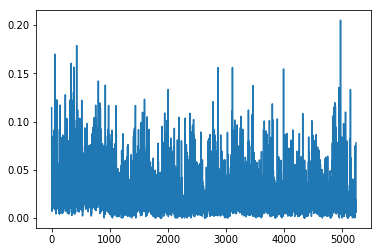

In [30]:
plt.plot(scores)